In [2]:
import os
import sys
import argparse
import wandb
import yaml
from yaml.loader import SafeLoader
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.models.ensemble import Ensemble
from src.dataloaders.brats import BRATS
from src.utils import IoU, get_device


In [9]:
def train(model, epochs, opt, train_loader, val_loader, training_run_name, device):
    print('--amount of epochs--', epochs)
    for epoch in range(epochs):
        train_loss = 0.0
        train_iou = 0.0
        print(f'----------Epoch {epoch}/{epochs}\n', end='')
        for index, (inputs, targets, _) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            opt.zero_grad()
            criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.0115))
            ensemble_loss = []
            for logit in logits:
                cur_loss = criterion(logit, targets)
                ensemble_loss.append(cur_loss)
                print('loss', cur_loss)
            ensemble_loss = torch.stack(ensemble_loss).mean()
            # Backward pass & weight update
            ensemble_loss.backward()
            opt.step()
            # Calculate Loss and IoU
            print('1', train_loss)
            train_loss += ensemble_loss.item()
            print('2', train_loss)
            mean_sigmoid = torch.stack([torch.sigmoid(logit) for logit in logits]).mean(dim=0)
            train_iou += IoU(targets.detach(), mean_sigmoid.detach().ge(0.5))
            print(f'EPOCH: {epoch} INDEX: {index} LOSS: {train_loss/len(train_loader)} IOU: {train_iou /len(train_loader)}')

            if index == 2 and (not is_sweep):
                for batch_index in range(0, len(inputs)):
                    np_img = inputs.cpu().numpy()
                    np_target = targets.cpu().detach().numpy()
                    print('inputs', np_img.sum(), len(np.unique(np_img)) <= 2)
                    print('target', np_target.sum(), len(np.unique(np_target)) <= 2)
                    fig, ax = plt.subplots(2, 4, figsize=(16,16))
                    ax[0][0].imshow(np_img[0, 0, :, :])
                    ax[0][1].imshow(np_img[0, 1, :, :])
                    ax[0][2].imshow(np_img[0, 2, :, :])
                    ax[0][3].imshow(np_img[0, 3, :, :])
                    ax[1][0].imshow(np_target[0, 0, :, :])
                    for index_pred in range(0, len(logits)):
                        np_pred = torch.sigmoid(logits[index_pred].detach()).ge(0.5).cpu().detach().numpy()
                        print('pred', index_pred,  np_img.sum(), len(np.unique(np_img)) <= 2)
                        ax[1][1+index_pred].imshow(np_pred[0, 0, :, :])
                    plt.tight_layout()
                    plt.show()
        val_loss = 0
        val_iou = 0
        model.eval()
        with torch.no_grad():
            for index, (inputs, targets, _) in enumerate(val_loader):
                val_inputs, val_targets = inputs.to(device), targets.to(device)
                val_logits = model(val_inputs)
                val_ensemble_loss = []
                for logit in val_logits:
                    cur_loss = criterion(logit, val_targets)
                    val_ensemble_loss.append(cur_loss)
                    print('val_loss', cur_loss)
                val_ensemble_loss = torch.stack(val_ensemble_loss).mean()
                criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.0093))
                print('1', val_loss)
                val_loss += val_ensemble_loss.item()
                print('2', val_loss)
                mean_sigmoid = torch.stack([torch.sigmoid(logit) for logit in val_logits]).mean(dim=0)
                val_iou += IoU(val_targets.detach(), mean_sigmoid.detach().ge(0.5))
                print(f'VAL EP: {epoch} IN: {index} LOSS: {val_loss/len(val_loader)} IOU: {val_iou /len(val_loader)}')

        return model


Using mps
--amount of epochs-- 5
----------Epoch 0/5
loss tensor(0.6816, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5786, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7801, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 0.0
2 0.8205596804618835
iou - tp=0 fp=0 fn=0 iou1=1.0 iou2=0.0
EPOCH: 0 INDEX: 0 LOSS: 0.0004411611185278944 IOU: 0.0005376344086021505
loss tensor(0.5387, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(1.7146, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.9031, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 0.8205596804618835
2 2.02646142244339
iou - tp=0 fp=1353 fn=0 iou1=7.390983000684473e-12 iou2=0.0
EPOCH: 0 INDEX: 1 LOSS: 0.0010894953884104247 IOU: 0.0005376344086061241
loss tensor(0.5150, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(2.4160, device='mps:0', grad

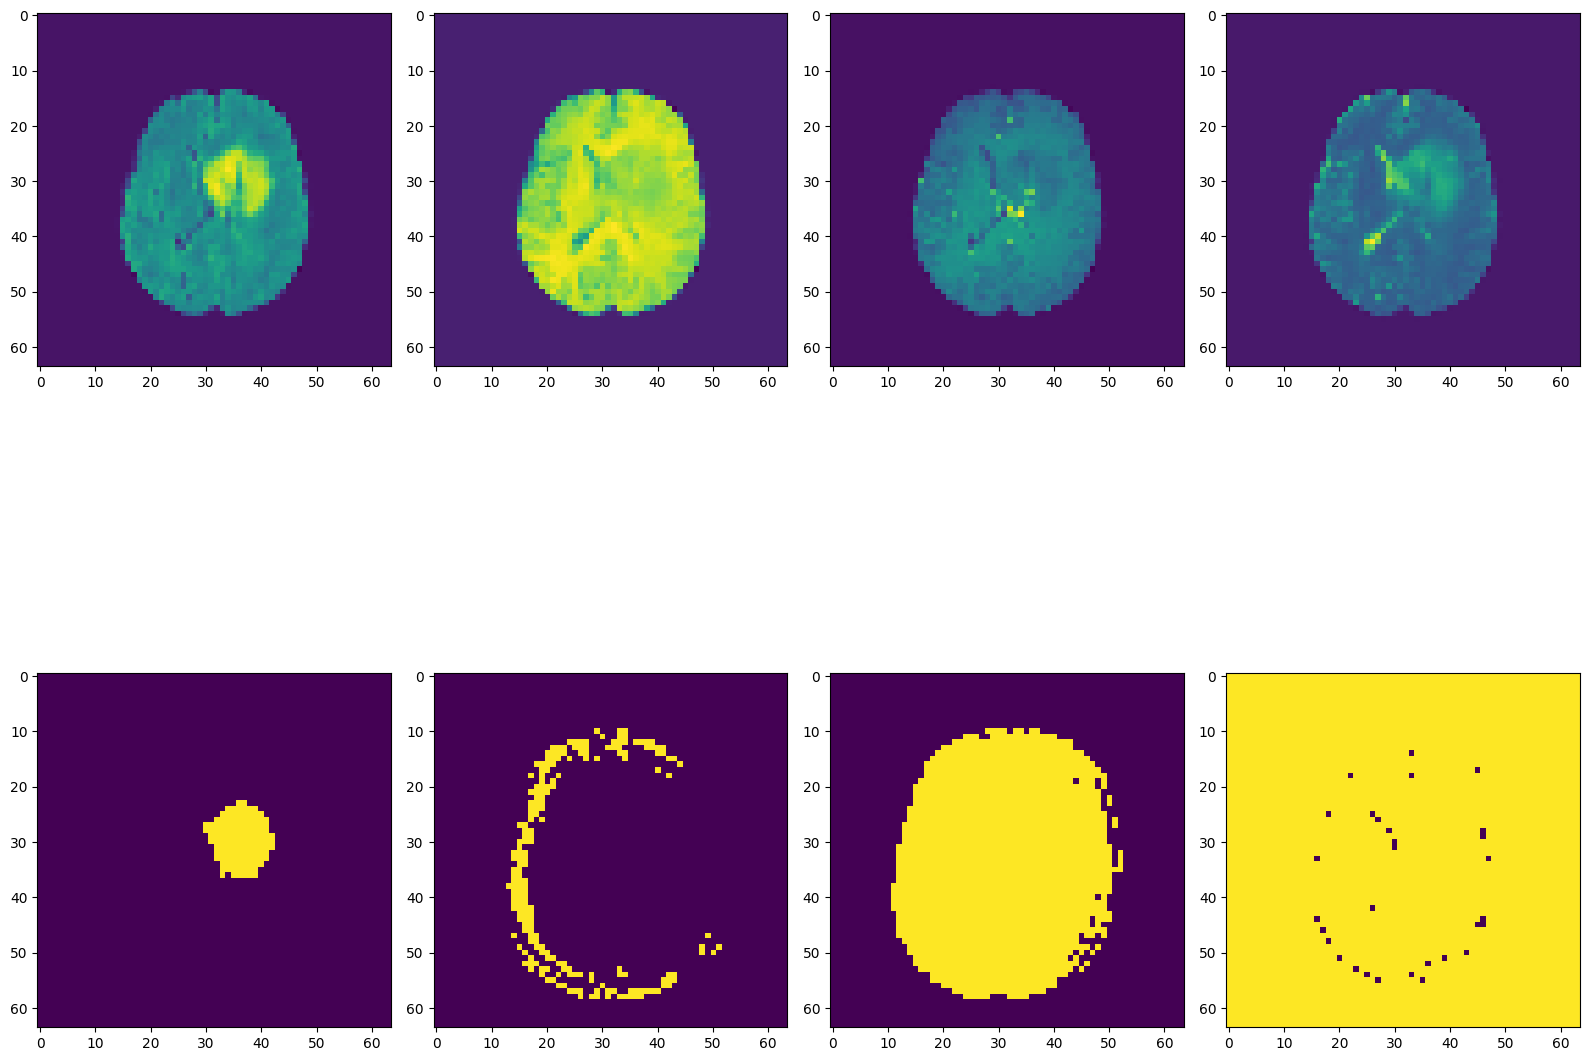

loss tensor(0.5771, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(1.3229, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7873, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 3.4456096291542053
2 4.4823179841041565
iou - tp=167 fp=751 fn=12 iou1=0.1795698924819401 iou2=0.17956989247118743
EPOCH: 0 INDEX: 3 LOSS: 0.002409848378550622 IOU: 0.0006800108767690934
loss tensor(0.6804, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.5779, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(0.7792, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
1 4.4823179841041565
2 5.267998993396759
iou - tp=0 fp=0 fn=0 iou1=1.0 iou2=0.0
EPOCH: 0 INDEX: 4 LOSS: 0.002832257523331591 IOU: 0.0012176452853712438
loss tensor(0.5678, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
loss tensor(1.2646, device='mps:0', grad_fn=<BinaryCrossEntropyW

RuntimeError: Parent directory res-2024_05_11_15_20 does not exist.

In [10]:

training_run_name = str(datetime.now())[:16].replace(" ", "_").replace("-", "_").replace(":", "_")
is_sweep = False
learning_rate = 0.0001
batch_size = 1
epochs = 5
img_size = 64
ensemble_size = 3

device = get_device()

torch.manual_seed(230)
if device == 'cuda':
    torch.cuda.manual_seed(230)

unet = Ensemble(training_run_name, ensemble_size, in_channel=4).to(device)

opt = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
train_set = BRATS('../../../../special-course/data/BRATS_20_images', mode="train", subset=0.6, size=[64, 64, 155])
valid_set = BRATS('../../../../special-course/data/BRATS_20_images', mode='val', subset=0.6, size=[64, 64, 155])

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)
torch.cuda.empty_cache()
trained_model = train(unet, epochs, opt, train_dataloader, valid_dataloader, training_run_name, device)
torch.save(trained_model.state_dict(), f'res-{training_run_name}/trained_model.pth')